[View in Colaboratory](https://colab.research.google.com/github/sreenithy/Optical-Flow/blob/master/Optical-Flow.ipynb)

In [28]:


def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


upload_files()

!ls

a.png  b.png  killeroo-simple-light.png  sample_data


Implementing Optical Flow using the opencv library

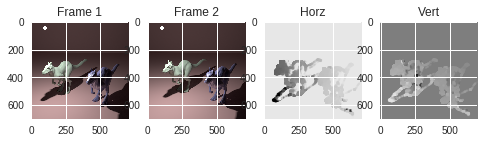

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

frame1 = cv2.imread('a.png')
frame2 = cv2.imread('b.png')
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
next1 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)


flow = cv2.calcOpticalFlowFarneback(prvs, next1, None,0.5, 3, 15, 3, 5, 1.2, 0)

horz = cv2.normalize(flow[...,0], None, 0, 255, cv2.NORM_MINMAX)
vert = cv2.normalize(flow[...,1], None, 0, 255, cv2.NORM_MINMAX)
horz = horz.astype('uint8')
vert = vert.astype('uint8')


plt.subplot(1, 4, 1)
plt.title('Frame 1')
plt.imshow(frame1, cmap=cm.gray)
plt.subplot(1, 4, 2)
plt.title('Frame 2')
plt.imshow(frame2, cmap=cm.gray)
plt.subplot(1, 4, 3)
plt.title('Horz')
plt.imshow(horz)
plt.subplot(1,4,4)
plt.title('Vert')
plt.imshow(vert)



Hard coding Lucas Kanade

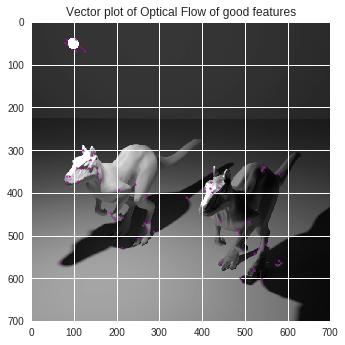

In [29]:
# import libraries
import math
from scipy import signal
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

import random


def LK_OpticalFlow(Image1, Image2):
    I1 = np.array(Image1)
    I2 = np.array(Image2)
    S = np.shape(I1)

    # applying Gaussian filter of size 3x3 to eliminate any noise
    I1_smooth = cv2.GaussianBlur(I1, (3, 3), 0)
    I2_smooth = cv2.GaussianBlur(I2, (3, 3), 0)

    # First Derivative in X direction
    Ix = signal.convolve2d(I1_smooth, [[-0.25, 0.25], [-0.25, 0.25]], 'same') + signal.convolve2d(I2_smooth,
                                                                                                  [[-0.25, 0.25],
                                                                                                   [-0.25, 0.25]],
                                                                                                  'same')
    # First Derivative in Y direction
    Iy = signal.convolve2d(I1_smooth, [[-0.25, -0.25], [0.25, 0.25]], 'same') + signal.convolve2d(I2_smooth,
                                                                                                  [[-0.25, -0.25],
                                                                                                   [0.25, 0.25]],
                                                                                                  'same')
    # First Derivative in XY direction
    It = signal.convolve2d(I1_smooth, [[0.25, 0.25], [0.25, 0.25]], 'same') + signal.convolve2d(I2_smooth,
                                                                                                [[-0.25, -0.25],
                                                                                                 [-0.25, -0.25]],
                                                                                                'same')

    # finding the good features
    features = cv2.goodFeaturesToTrack(I1_smooth  # Input image
                                       , 10000  # max corners
                                       , 0.01  # lambda 1 (quality)
                                       , 10  # lambda 2 (quality)
                                       )

    feature = np.int0(features)

    for i in feature:
        x, y = i.ravel()
        cv2.circle(I1_smooth  # input image
                   , (x, y)  # centre
                   , 3  # radius
                   , 0  # color of the circle
                   , -1  # thickness of the outline
                   )

    # creating the u and v vector
    u = v = np.nan * np.ones(S)

    # Calculating the u and v arrays for the good features obtained n the previous step.
    for l in feature:
        j, i = l.ravel()
        # calculating the derivatives for the neighbouring pixels
        # since we are using  a 3*3 window, we have 9 elements for each derivative.

        IX = ([Ix[i - 1, j - 1], Ix[i, j - 1], Ix[i - 1, j - 1], Ix[i - 1, j], Ix[i, j], Ix[i + 1, j], Ix[i - 1, j + 1],
               Ix[i, j + 1], Ix[i + 1, j - 1]])  # The x-component of the gradient vector
        IY = ([Iy[i - 1, j - 1], Iy[i, j - 1], Iy[i - 1, j - 1], Iy[i - 1, j], Iy[i, j], Iy[i + 1, j], Iy[i - 1, j + 1],
               Iy[i, j + 1], Iy[i + 1, j - 1]])  # The Y-component of the gradient vector
        IT = ([It[i - 1, j - 1], It[i, j - 1], It[i - 1, j - 1], It[i - 1, j], It[i, j], It[i + 1, j], It[i - 1, j + 1],
               It[i, j + 1], It[i + 1, j - 1]])  # The XY-component of the gradient vector

        # Using the minimum least squares solution approach
        LK = (IX, IY)
        LK = np.matrix(LK)
        LK_T = np.array(np.matrix(LK))  # transpose of A
        LK = np.array(np.matrix.transpose(LK))

        A1 = np.dot(LK_T, LK)  # Psedudo Inverse
        A2 = np.linalg.pinv(A1)
        A3 = np.dot(A2, LK_T)

        (u[i, j], v[i, j]) = np.dot(A3, IT)  # we have the vectors with minimized square error
    
    #plt.imshow(u)
    
    # ======= Pick Random color for vector plot========
    colors = "bgrcmykw"
    color_index = random.randrange(0, 8)
    c = colors[color_index]
    # ======= Plotting the vectors on the image========
    #plt.subplot(1, 3, 3)
    plt.title('Vector plot of Optical Flow of good features')
    plt.imshow(I1, cmap=cm.gray)
    for i in range(S[0]):
        for j in range(S[1]):
            if abs(u[i, j]) > t or abs(v[i, j]) > t:  # setting the threshold to plot the vectors
                plt.arrow(j, i, v[i, j], u[i, j], head_width=5, head_length=5, color=c)

    plt.show()
    

t = 0.3  # choose threshold value
# import the images

Image5 = Image.open('a.png').convert('L')
Image6 = Image.open('killeroo-simple-light.png').convert('L')
LK_OpticalFlow(Image5, Image6)


